# PINN learning of Kuramoto-Sivashinsky equation

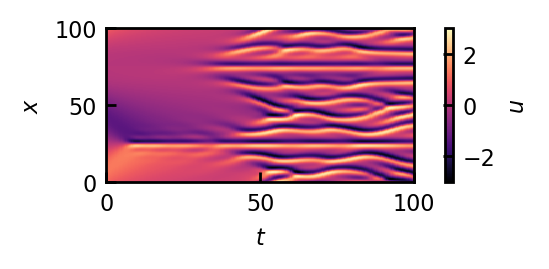

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/kuramoto_sivashinsky.mat')
U_star = data['uu']
t_star = data['tt'].T
x_star = data['x']

N = x_star.shape[0]
T = t_star.shape[0]

# Reshape data
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

# Plot data
def plot_field(ax, u, vmin=-3, vmax=3, label='$u$'):
    im = ax.pcolormesh(TT, XX, u, cmap='magma', vmin=vmin, vmax=vmax)
    ax.set(xlabel='$t$', xlim=[0, 100], xticks=[0, 50, 100],
           ylabel='$x$', ylim=[0, 100], yticks=[0, 50, 100],
           aspect=0.5)
    plt.colorbar(im, ax=ax, label=label)

fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_field(ax, U_star)

# Solve BVP with PINN

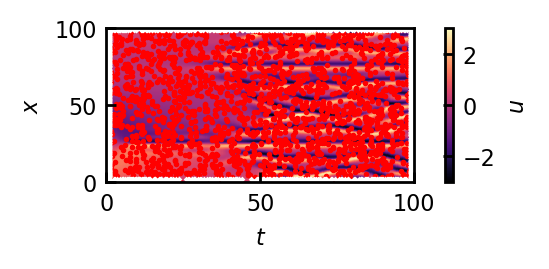

In [2]:
# Select points for bulk physics-informed loss
N_f = 2000
idx = np.random.choice(N*T, N_f, replace=False)
x_f, t_f, u_f = x[idx,:], t[idx,:], u[idx,:]

# Select boundary points for reconstruction loss
N_u = 1000
idxs = np.argwhere(np.logical_or(
    np.logical_or(x == x.min(), x == x.max()),
    np.logical_or(t == t.min(), t == t.max())
))[:, 0]
idx = np.random.choice(idxs, N_u, replace=False)
x_b, t_b, u_b = x[idx,:], t[idx,:], u[idx,:]

# Plot both sets of points
fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_field(ax, U_star)
ax.scatter(t_f, x_f, c='red', s=1)
ax.scatter(t_b, x_b, c='white', marker='x', s=10)

In [4]:
import torch
from kuramoto_sivashinsky_pinn import KuramotoSivashinskyBVPPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = KuramotoSivashinskyBVPPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
        x_b=x_b,
        t_b=t_b,
        u_b=u_b,
    ),
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 1.67252e-01, MSE: 1.49114e-01, Phys: 1.81378e-02
Iteration 2000, Loss: 1.34362e-01, MSE: 1.25209e-01, Phys: 9.15239e-03
Iteration 3000, Loss: 1.12079e-01, MSE: 1.05627e-01, Phys: 6.45151e-03
Iteration 4000, Loss: 7.30779e-02, MSE: 6.77690e-02, Phys: 5.30894e-03
Iteration 5000, Loss: 5.53278e-02, MSE: 5.06542e-02, Phys: 4.67361e-03
Iteration 6000, Loss: 4.35456e-02, MSE: 3.92361e-02, Phys: 4.30952e-03
Iteration 7000, Loss: 4.00963e-02, MSE: 3.58339e-02, Phys: 4.26239e-03
Iteration 8000, Loss: 3.69029e-02, MSE: 3.32614e-02, Phys: 3.64149e-03
Iteration 9000, Loss: 3.43802e-02, MSE: 3.11464e-02, Phys: 3.23383e-03
Iteration 10000, Loss: 3.24405e-02, MSE: 3.00407e-02, Phys: 2.39981e-03
Iteration 11000, Loss: 3.18202e-02, MSE: 2.97476e-02, Phys: 2.07265e-03
Iteration 12000, Loss: 3.12138e-02, MSE: 2.93275e-02, Phys: 1.88633e-03
Iteration 13000, Loss: 3.04907e-02, MSE: 2.89110e-02, Phys: 1.57970e-03
Iteration 14000, Loss: 2.93868e-02, MS

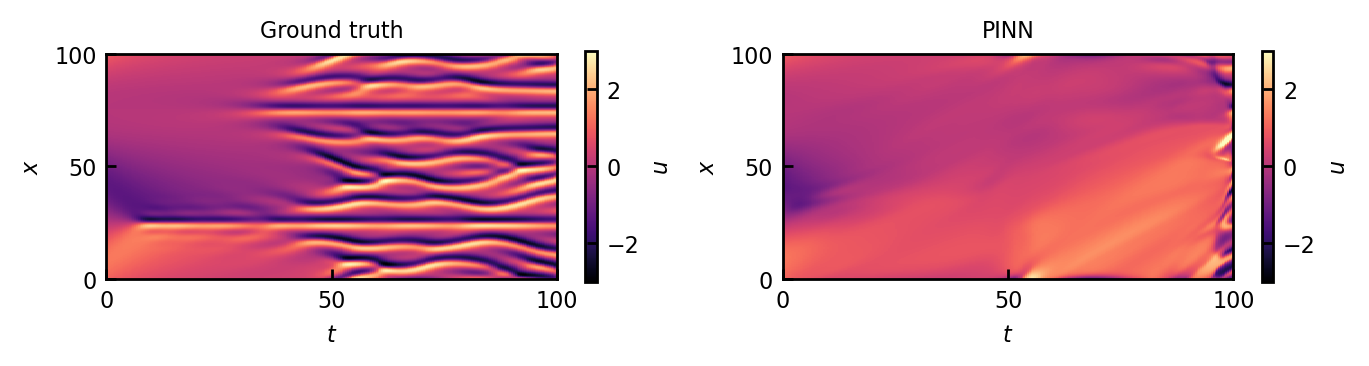

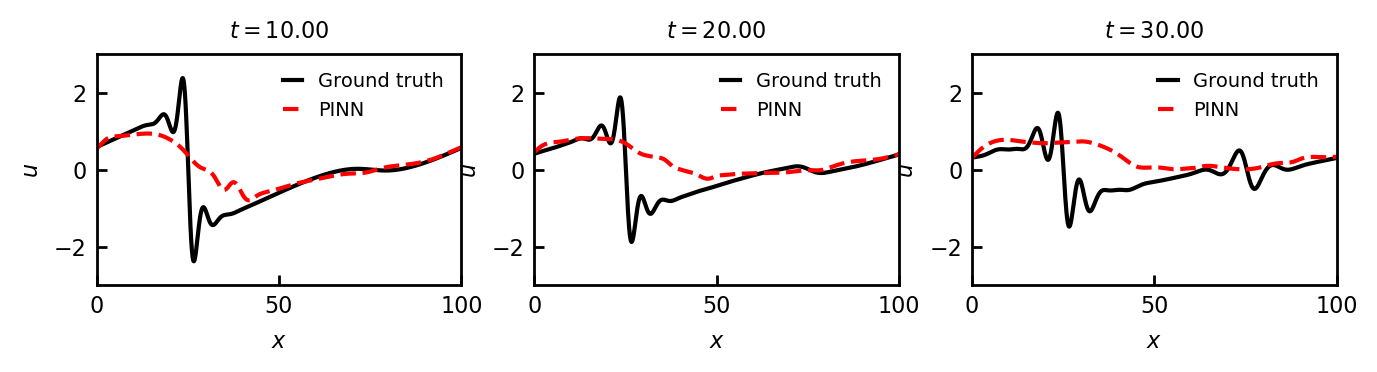

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star)
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred)
ax[1].set_title('PINN')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[0, 100], xticks=[0, 50, 100], 
          ylabel='$u$', ylim=[-3, 3], yticks=[-2, 0, 2])
    a.legend()

# Learn parameters with PINN

$$ u_t + u u_x + u_{xx} + u_{xxxx} = 0 $$

In [6]:
import torch
from kuramoto_sivashinsky_pinn import KuramotoSivashinskyParameterPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = KuramotoSivashinskyParameterPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
    ),
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 1.73743e-01, MSE: 1.51978e-01, Phys: 2.17647e-02
Iteration 2000, Loss: 8.66950e-02, MSE: 7.33271e-02, Phys: 1.33679e-02
Iteration 3000, Loss: 6.76361e-02, MSE: 5.67755e-02, Phys: 1.08606e-02
Iteration 4000, Loss: 5.18919e-02, MSE: 4.25961e-02, Phys: 9.29582e-03
Iteration 5000, Loss: 4.37696e-02, MSE: 3.56424e-02, Phys: 8.12726e-03
Iteration 6000, Loss: 3.59510e-02, MSE: 2.80410e-02, Phys: 7.90995e-03
Iteration 7000, Loss: 3.14719e-02, MSE: 2.50784e-02, Phys: 6.39345e-03
Iteration 8000, Loss: 2.86642e-02, MSE: 2.31875e-02, Phys: 5.47671e-03
Iteration 9000, Loss: 2.65565e-02, MSE: 2.12530e-02, Phys: 5.30344e-03
Iteration 10000, Loss: 2.44804e-02, MSE: 1.94625e-02, Phys: 5.01789e-03
Iteration 11000, Loss: 2.25322e-02, MSE: 1.78371e-02, Phys: 4.69508e-03
Iteration 12000, Loss: 2.08041e-02, MSE: 1.62062e-02, Phys: 4.59791e-03
Iteration 13000, Loss: 1.91042e-02, MSE: 1.46872e-02, Phys: 4.41700e-03
Iteration 14000, Loss: 1.76445e-02, MS

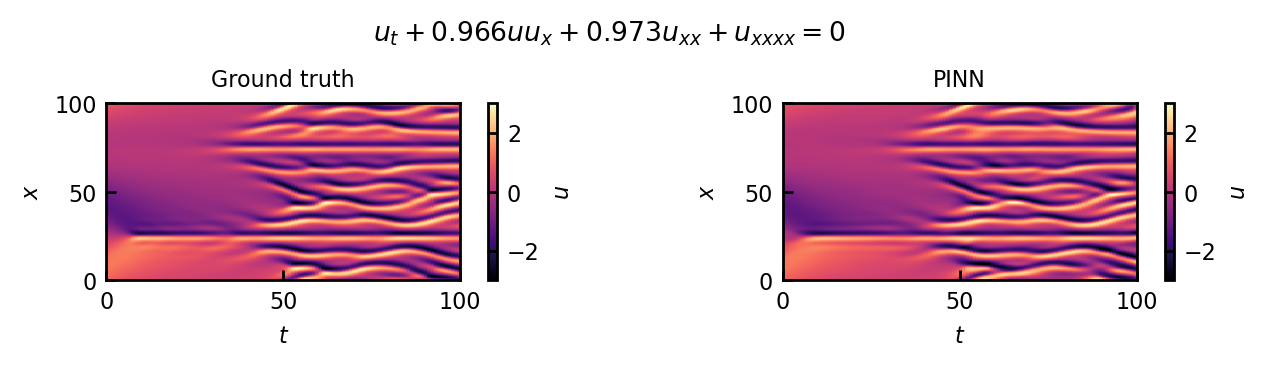

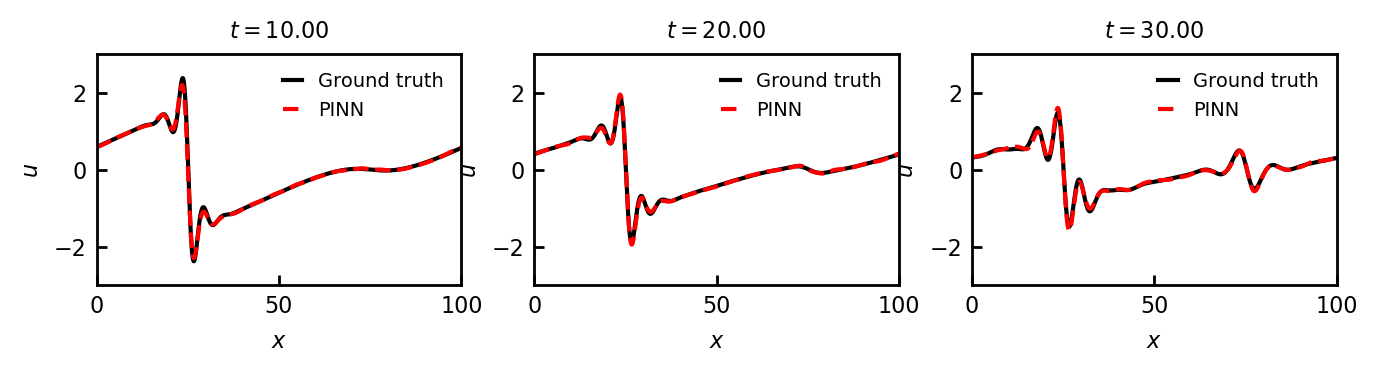

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star)
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred)
ax[1].set_title('PINN')

fig.subplots_adjust(top=0.7)
lambda_1, lambda_2 = model.get_params()
fig.suptitle(f'$u_t + {lambda_1.detach().item():.3g} u u_x + {lambda_2.detach().item():.3g} u_{{xx}} + u_{{xxxx}} = 0$')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[0, 100], xticks=[0, 50, 100], 
          ylabel='$u$', ylim=[-3, 3], yticks=[-2, 0, 2])
    a.legend()